## 이미지 불러오기

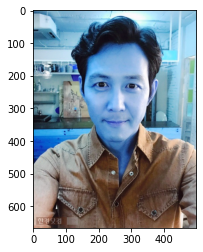

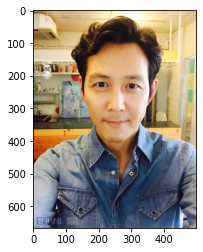

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

path_face = './img/test_img.png'
# OpenCV: 이미지를 불러오기
img_ori = cv2.imread(path_face)    
plt.imshow(img_ori)
plt.show()

# openCV(BGR) to RGB 변환 
img_rgb = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Face detection

In [2]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출 [[x_1, x_2], [y_1, y_2]]
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)

rectangles[[(142, 167) (365, 390)]]


142 167 365 390


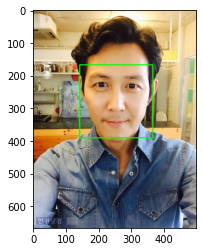

In [3]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다. return -> list
img_box = img_rgb.copy()
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l, t, r, b)

    # dlib.rectangles(img, start_point, end_point, line_color, line_width, line_type)    
    cv2.rectangle(img_box, (l, t), (r, b), (0,255,0), 2, lineType=cv2.LINE_AA)

#img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_box)
plt.show()

## Face landmark

68


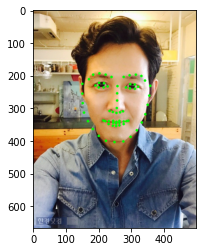

In [4]:
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
img_mark = img_rgb.copy()
# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_mark, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_mark, point, 4, (0, 255, 0), -1)

plt.imshow(img_mark)
plt.show()

## sticker 적용

In [5]:
# 사진에 따라 위치가 변하기 떄문에
# 스티커의 크기는 detection rect에 의해 정함
x_nose = 0
y_nose = 0
w_rect = 0
h_rect = 0

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 코의 index : 30
    # landmark[30] = (x, y)
    print (landmark[30]) 
    x_nose = landmark[30][0]
    y_nose = landmark[30][1]
    w_rect = dlib_rect.width()
    h_rect = dlib_rect.height()
    print ('(x_nose, y_nose) : (%d,%d)'%(x_nose, y_nose))
    print ('(w_rect, h_rect) : (%d,%d)'%(w_rect, h_rect))

(255, 299)
(x_nose, y_nose) : (255,299)
(w_rect, h_rect) : (224,224)


[255 255 255]


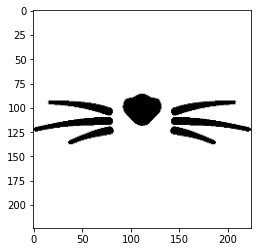

In [6]:
path_sticker = './img/cat-whiskers.png'
img_sticker = cv2.imread(path_sticker) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w_rect, h_rect))

print (img_sticker[0][0])
plt.imshow(img_sticker)
plt.show()

In [7]:
# 계산결과 -값이 존재
# 사진을 벗어나는 영역 존재
refined_x = x_nose - w_rect // 2
refined_y = y_nose - h_rect // 2
print ('(x_nose, y_nose) : (%d,%d)'%(refined_x, refined_y))


(x_nose, y_nose) : (143,187)


(x_nose, y_nose) : (143,187)


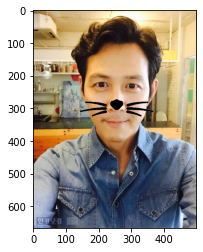

In [8]:
# 사진 영역을 벗어나는 sticker 이미지 편집
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x_nose, y_nose) : (%d,%d)'%(refined_x, refined_y))

img_face_sticker = img_rgb.copy()
# img에서 sticker가 들어갈 지역 추출
x_start_refined = refined_y
x_finish_refined = refined_y+img_sticker.shape[0]
y_start_refined = refined_x
y_finish_refined = refined_x+img_sticker.shape[1]
area_sticker = img_face_sticker[x_start_refined:x_finish_refined, y_start_refined:y_finish_refined]

# sticker 이미지의 투명(값이 0)인 부분에 원본 이미지의 값을 채워 넣어줌
# np.where : 조건에 맞는 인덱스 찾기 및 값 변경
# np.where(condition, T, F)
# np.where(조건, 참일때 값, 거짓일떄 값)

edit_img_sticker = np.where(img_sticker==255, area_sticker, img_sticker).astype(np.uint8)
img_face_sticker[x_start_refined:x_finish_refined, refined_x:y_finish_refined] = edit_img_sticker

plt.imshow(img_face_sticker)
plt.show()

# 추가

## 투명도 조절

In [2]:
import os, re 
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

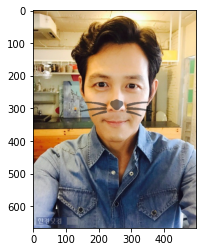

In [10]:
img_face_sticker = img_rgb.copy()
# img에서 sticker가 들어갈 지역 추출
x_start_refined = refined_y
x_finish_refined = refined_y+img_sticker.shape[0]
y_start_refined = refined_x
y_finish_refined = refined_x+img_sticker.shape[1]
area_sticker = img_face_sticker[x_start_refined:x_finish_refined, y_start_refined:y_finish_refined]

img_weight_face_sticker = cv2.addWeighted(area_sticker, 0.5, img_sticker, 0.5, 0)

edit_img_sticker = np.where(img_sticker==255, area_sticker, img_weight_face_sticker).astype(np.uint8)
img_face_sticker[x_start_refined:x_finish_refined, refined_x:y_finish_refined] = edit_img_sticker

plt.imshow(img_face_sticker)
plt.show()

## 각도 대응

### detection, landmark

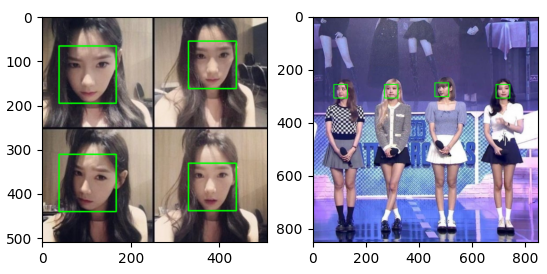


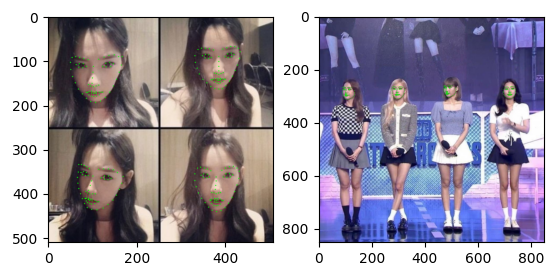

### 각도에 따른 이미지 변형

landmark의 기준으로 얼굴 각도를 계산하고<br>
코끝을 기준으로 오른쪽 얼굴과 왼쪽 얼굴의 비를 계산하여<br>
이미지를 변형

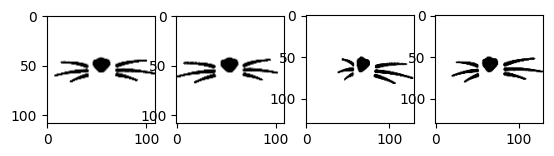
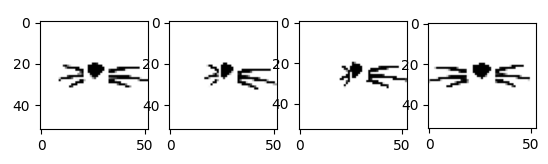

### 합성

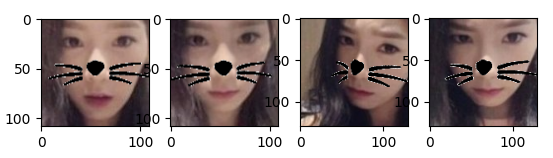
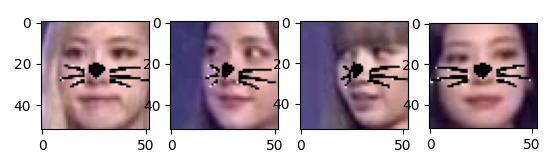

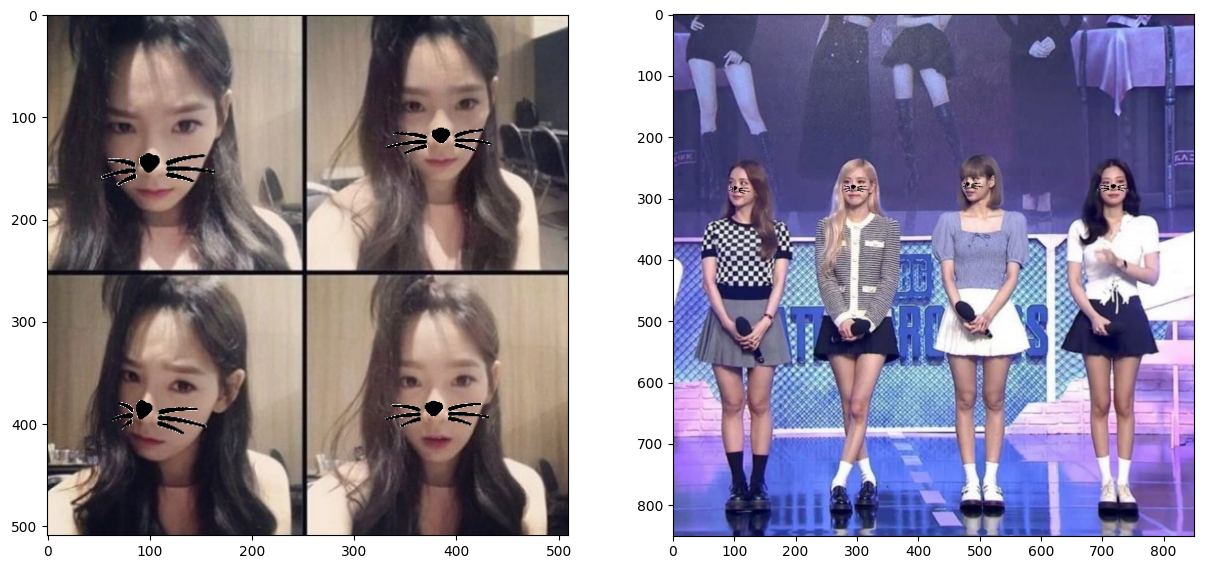

## 어두운 사진

1번의 표정이 과한 사진과 3번의 얼굴이 반가려진 사진은 detection과 landmark가 실행되지 않음<br>
4번의 턱 윤곽이 가려진 사진은 제대로 detection과 landmark가 이루어짐<br>

### detection


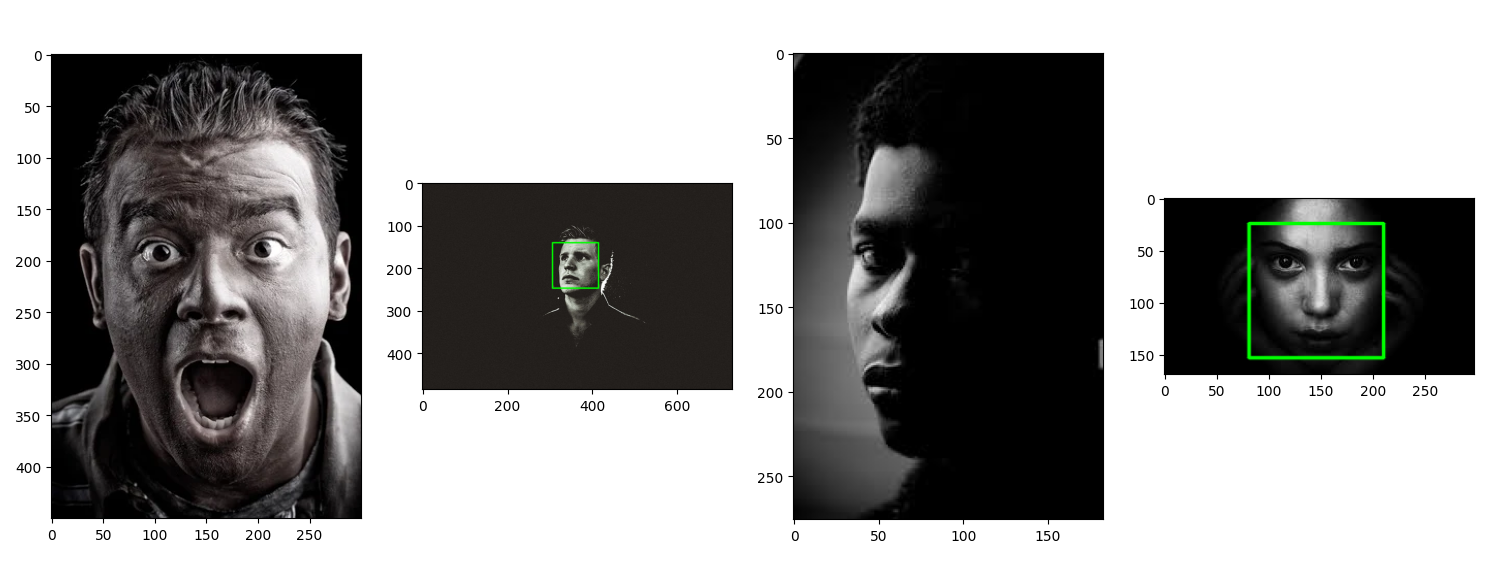

### landmark

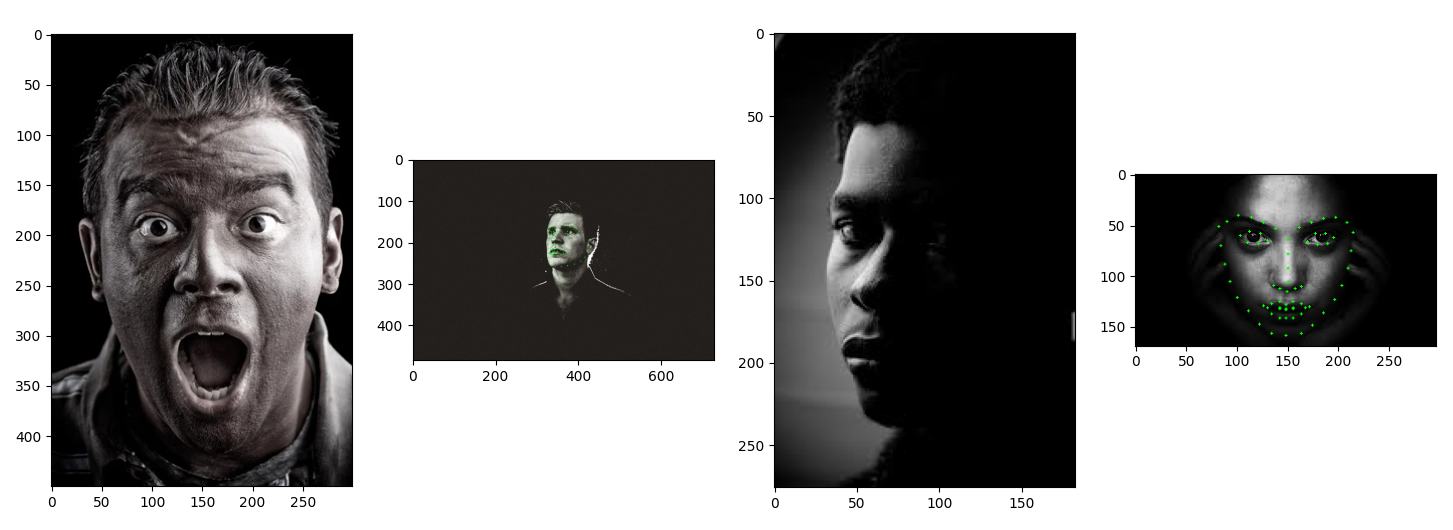


### 강제 landmark

detection이 되지 않아 강제로 얼굴의 범위를 지정하여 landmark를 실행함<br>
1번의 표정이 과한 사진은 턱 윤곽은 대략적으로 marking되었지만 이목구비가 제대로 인식되지 않음
2번 사진은 턱 윤곽이 제대로 marking 되지 않음

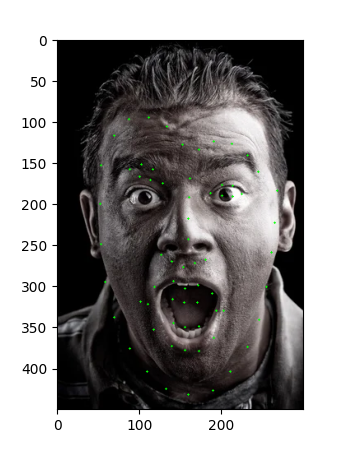 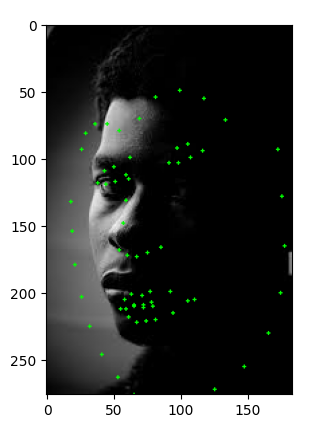

## 멀리 있는 사진

멀리 있어도 이목구비나 얼굴 윤곽이 제대로 보이는 사진은 detection과 landmark가 수행됨

### detection


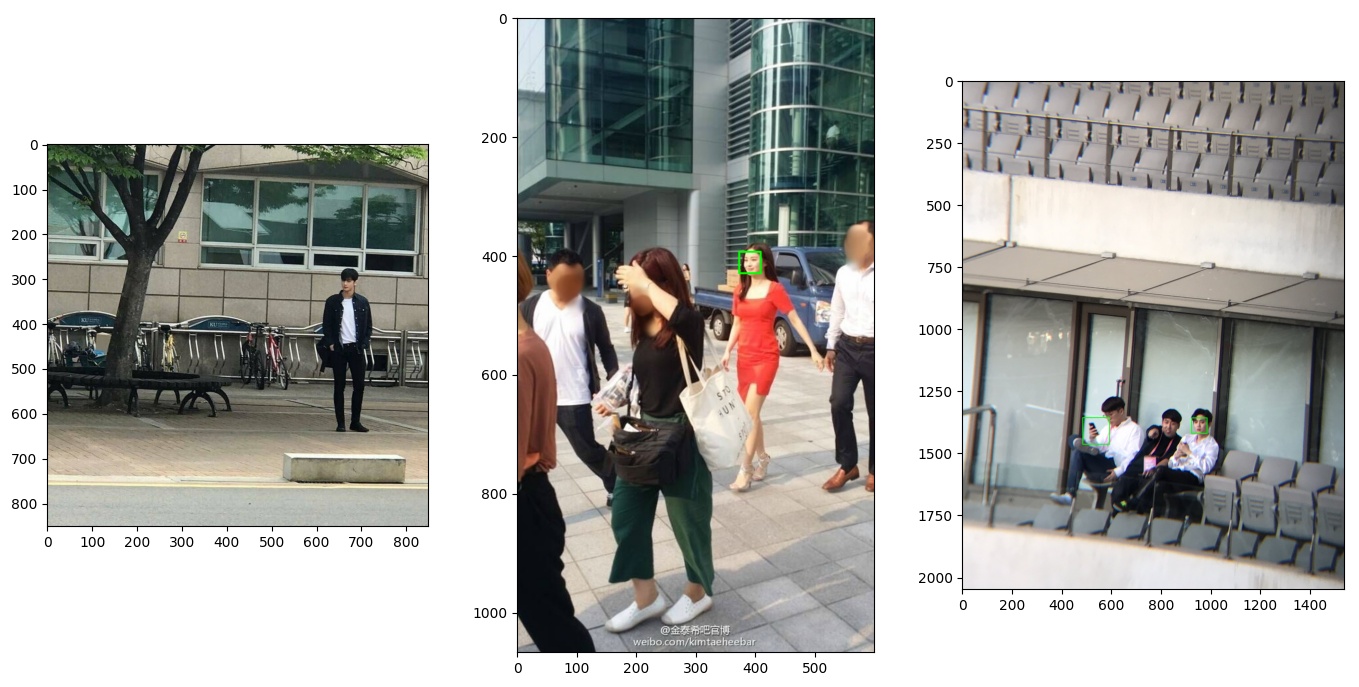

### landmark

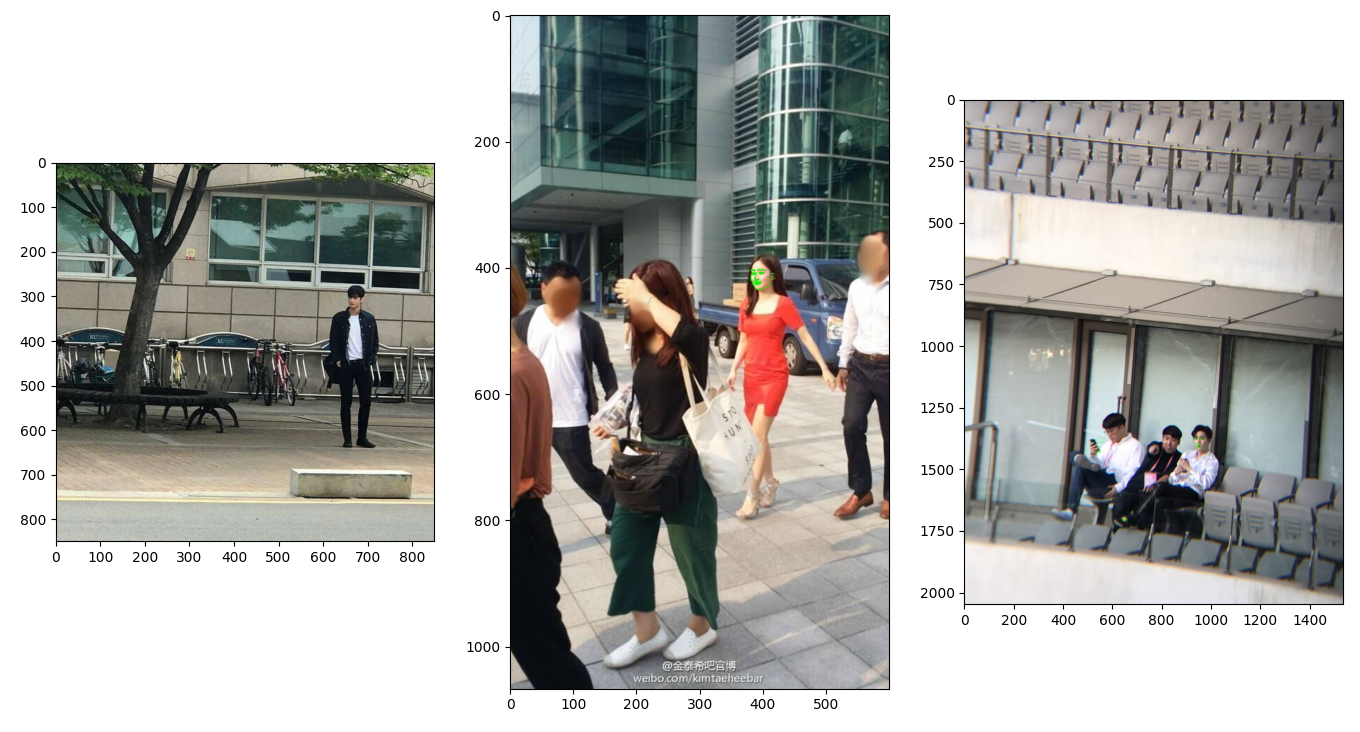

## 일부가 가려진 사진

턱 윤곽이 일부 가려졌지만 이목구비가 선명한 사진인 2번은 제대로 detection과 landmark가 수행됨

### detection


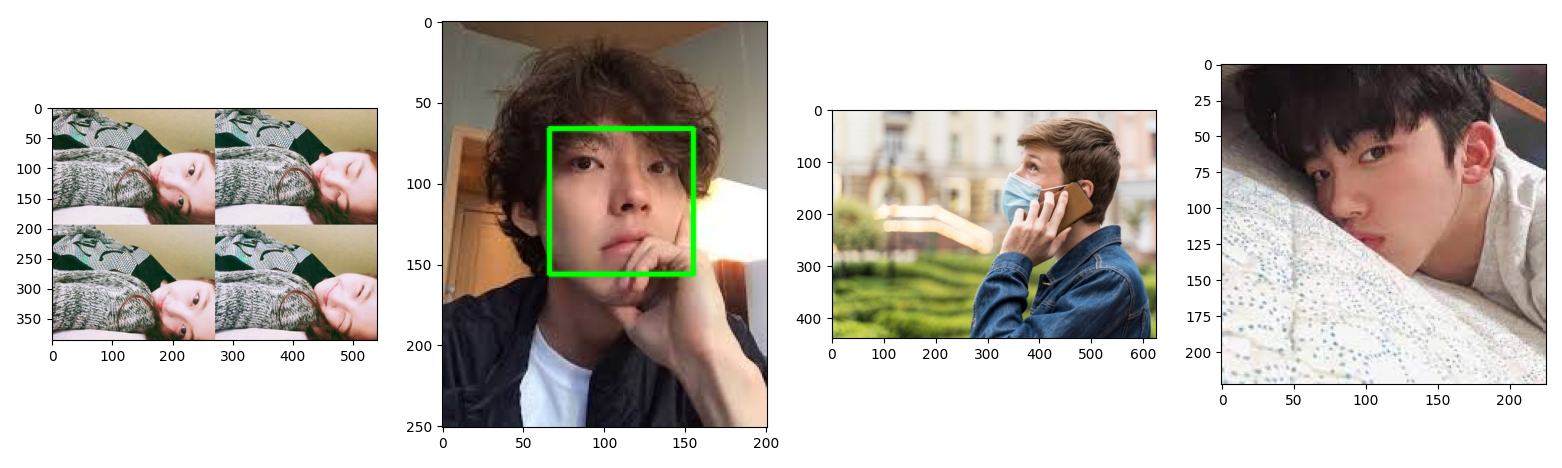

### landmark

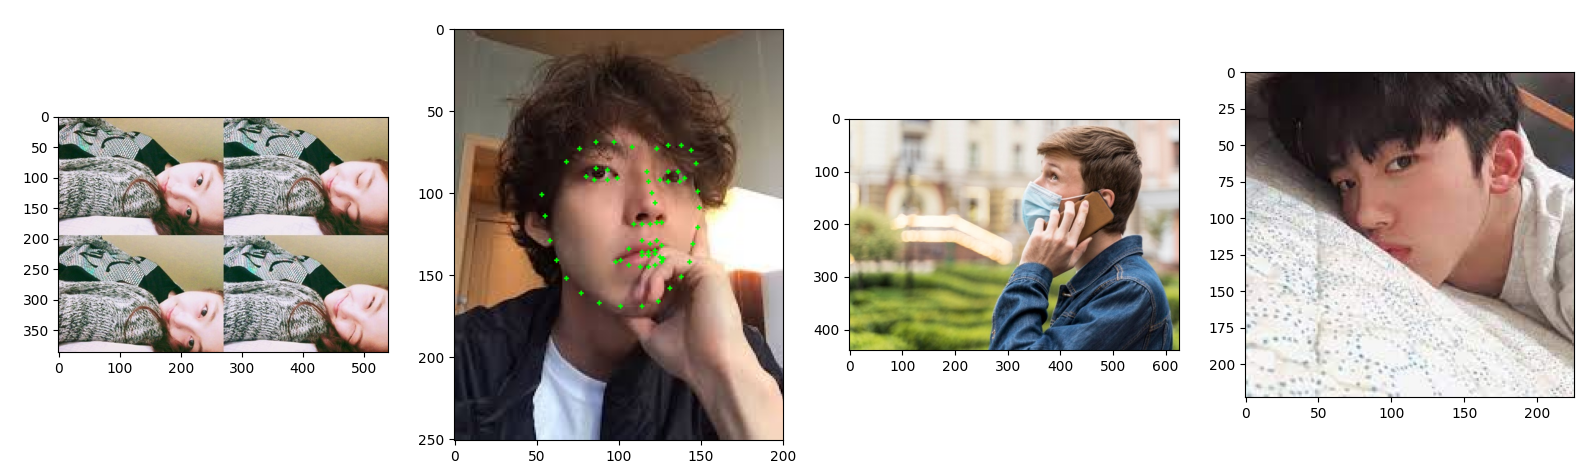

### 강제 landmark

1번 사진과 4번 사진은
윤곽이 조금 가려졌더라도 이목구비가 보이는 사진인데 제대로 detection과 landmark가 수행되지 않음

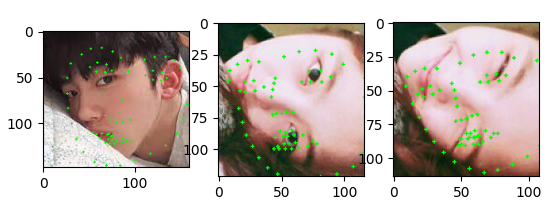

detection과 landmark 과정에서 
단순히 눈, 코, 입, 턱이 개별적으로 검출하는 것이 아니라
서로 검출에 관여하는 것으로 생각이 된다.
해당 모델의 검출 방법을 학습해 보는것이 필요함.